In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,cross_val_score,StratifiedKFold,cross_val_predict
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.dummy import DummyClassifier
import time
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
from sklearn.metrics import accuracy_score, roc_auc_score,classification_report,confusion_matrix,roc_curve
warnings.filterwarnings('ignore')

**application train et test**

In [3]:
#importer nos tables 
application_train=pd.read_csv("C:/Users/Lenovo/application_train.csv")

In [4]:
application_test=pd.read_csv("C:/Users/Lenovo/application_test.csv")

In [ ]:
application

**bureau et bureau_balance**

In [ ]:
bureau=pd.read_csv("C:/Users/Lenovo/bureau.csv")
bureau.shape

In [6]:
#identifiantid dans cette table est SK_ID_BUREAU
#Données concernant les crédits antérieurs du client auprès d’autres institutions financières. Chaque crédit précédent a sa propre ligne dans le bureau
#,mais un prêt dans les données de la demande peut avoir plusieurs crédits précédents.
bureau.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [7]:
bureau['SK_ID_BUREAU'].duplicated().sum()

0

In [8]:
#données mensuelles sur les crédits précédents en bureau. 
#Chaque ligne correspond à un mois d’un crédit précédent
#et un seul crédit précédent peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
bureau_balance=pd.read_csv("C:/Users/Lenovo/bureau_balance.csv")
bureau_balance.shape

(27299925, 3)

**payment et credit card**

In [9]:
#historique de paiement des prêts précédents chez Home Credit. 
#Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.
payment=pd.read_csv("C:/Users/Lenovo/installments_payments.csv")
payment.shape

(13605401, 8)

In [10]:
#données mensuelles sur les cartes de crédit précédentes que les clients ont eues avec Home Credit. Chaque ligne correspond à un mois du solde d’une carte de crédit,
#et une seule carte de crédit peut avoir plusieurs lignes.
credit_card=pd.read_csv("C:/Users/Lenovo/credit_card_balance.csv")
credit_card.shape

(3840312, 23)

In [10]:
sample_submission=pd.read_csv("C:/Users/Lenovo/sample_submission.csv")
sample_submission.shape

(48744, 2)

**POS_CASH_BALANCE et previous_application**

In [11]:
#POS_CASH_BALANCE : données mensuelles sur les précédents prêts au point de vente ou de trésorerie que les clients ont contractés auprès de Home Credit.
#Chaque ligne correspond à un mois d’un point de vente ou d’un prêt de trésorerie précédent,
#et un seul prêt précédent peut avoir plusieurs lignes.
pos_cash=pd.read_csv("C:/Users/Lenovo/POS_CASH_balance.csv")
pos_cash.shape

(10001358, 8)

In [12]:
#demandes antérieures de prêts chez Home Credit des clients qui ont des prêts dans les données de la demande.
#Chaque prêt en cours dans les données de la demande peut avoir plusieurs prêts antérieurs.
#Chaque application précédente comporte une ligne et est identifiée par la fonction SK_ID_PREV.
previous_application=pd.read_csv("C:/Users/Lenovo/previous_application.csv")
previous_application.shape

(1670214, 37)

In [13]:
import chardet
with open("HomeCredit_columns_description.csv", 'rb') as f:
    result = chardet.detect(f.read())
result

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}

In [14]:
homecredit = pd.read_csv("HomeCredit_columns_description.csv", encoding='Windows-1252')
homecredit.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


## Analyse exploratoire 

### Application_train

Nous allons verifier :
- les missing values
- shape et types et nombre de valeur unique par categories
- label encoder et one-hot 
- Aligning Training and Testing Data=Il doit y avoir les mêmes caractéristiques (colonnes) dans les données d’entraînement
#et de test. L’encodage à chaud a créé plus de colonnes dans les données d’apprentissage,
#car certaines variables catégorielles comportaient des catégories non représentées dans les données de test.
#Pour supprimer les colonnes des données d’entraînement qui ne figurent pas dans les données de test,
#nous devons aligner les trames de données. Tout d’abord, nous extrayons la colonne cible des données d’entraînement
#(car ce n’est pas dans les données de test, mais nous devons conserver ces informations).
#Lorsque nous faisons l’alignement, nous devons nous assurer de définir axis = 1 pour aligner les trames de données
#en fonction des colonnes et non des lignes !
-etudier les anomalies anomalies¶
- detecter les correlations

In [4]:
#fct infos de base pour chaque table

def infos_table(data):
    print('-' * 79)
    # Taille : nombre de lignes/colonnes
    nRow, nVar = data.shape
    print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')
    print('-' * 79)
    duplicate = \
        data.shape[0] - data.duplicated().shape[0]
    print(f'Numbre de valeurs dupliquées dans  ce data est : {duplicate}')
    print('-' * 79)
    print('Contenu des 3 premières lignes :')
    display(data.head(3))

In [5]:
infos_table(application_train)

-------------------------------------------------------------------------------
Le jeu de données contient 307511 lignes et 122 variables.
-------------------------------------------------------------------------------
Numbre de valeurs dupliquées dans  ce data est : 0
-------------------------------------------------------------------------------
Contenu des 3 premières lignes :


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# fct qui detecte les valeurs manquantes 
def missing_values_table(df):
    
    mis_val_pourcent= df.isna().sum() * 100 / len(df)
    data= pd.DataFrame({'column' : mis_val_pourcent.index, 'percent' : mis_val_pourcent.values})
        
        # Sort the table by percentage of missing descending
    data.sort_values(by='percent', ascending=False, inplace=True)
    return data

In [7]:
missing_values_table(application_train)

,column,percent
76,COMMONAREA_MEDI,69.872297
48,COMMONAREA_AVG,69.872297
62,COMMONAREA_MODE,69.872297
70,NONLIVINGAPARTMENTS_MODE,69.432963
56,NONLIVINGAPARTMENTS_AVG,69.432963
...,...,...
15,NAME_HOUSING_TYPE,0.000000
14,NAME_FAMILY_STATUS,0.000000
13,NAME_EDUCATION_TYPE,0.000000
12,NAME_INCOME_TYPE,0.000000


In [8]:
def plot_nan_percent(df_nan, tight_layout = True):
    figsize=(20,8)
    
    #checking if there is any column with NaNs or not
        
    #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
    plt.xticks(rotation = 90)
    plt.xlabel('Column Name')
    plt.ylabel('Percentage of NaN values')
    plt.title(f'Percentage of NaN values in this data')
    plt.show()

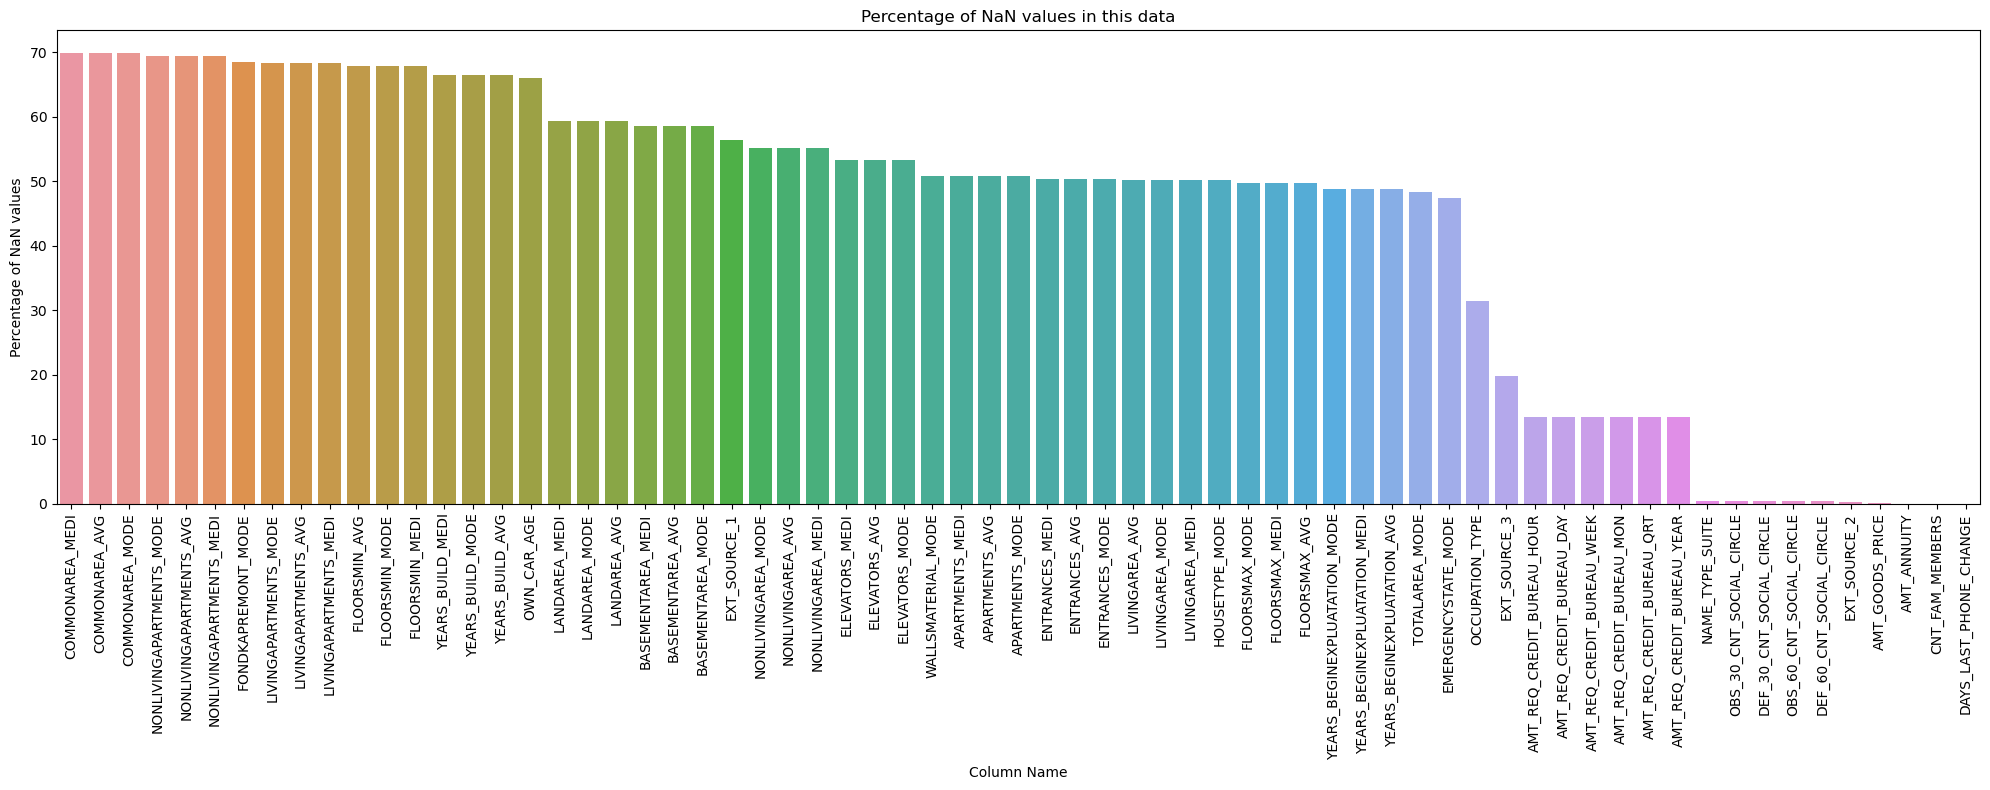

In [9]:
plot_nan_percent(missing_values_table(application_train),tight_layout=True)

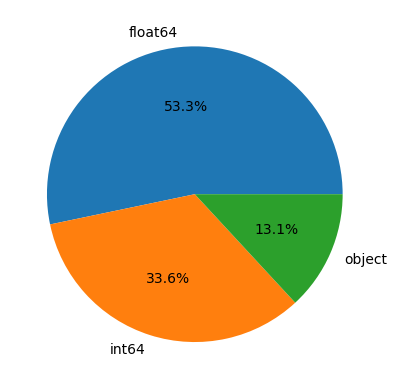

In [10]:
# types des features
application_train.dtypes.value_counts()
application_train.dtypes.value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.show()

#### Analyse univariee

In [11]:
# La target
application_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64


sns.barplot(x=[0, 1],y=application_train['TARGET'].value_counts(normalize=True), palette=['SteelBlue', 'crimson'])
for i, v in enumerate(application_train['TARGET']):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center', color='black', fontweight='bold')

# Titre du graphique
plt.title('Distribution de la TARGET')

# Affichage du graphique
plt.show()

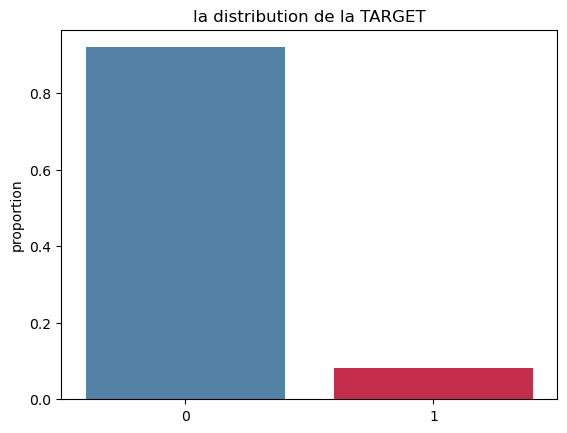

In [12]:
sns.barplot(x=[0, 1],y=application_train['TARGET'].value_counts(normalize=True), palette=['SteelBlue', 'crimson'])
plt.title('la distribution de la TARGET')
plt.show()

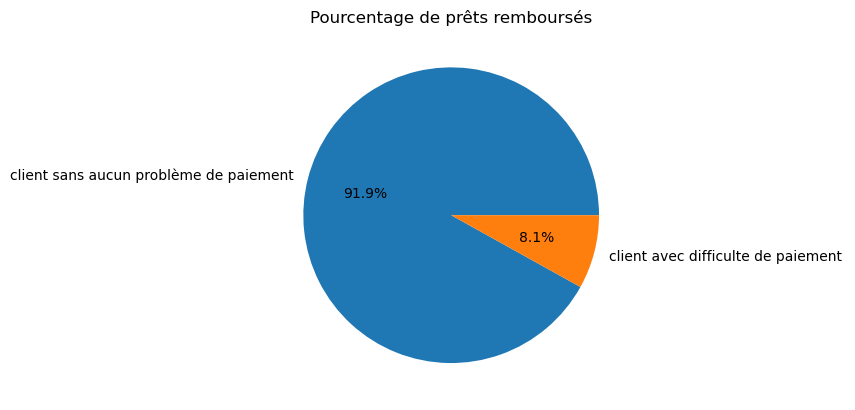

In [13]:
fig = plt.figure()
plt.pie(application_train['TARGET'].value_counts()/len(application_train)*100,
        autopct='%1.1f%%',
        labels=["client sans aucun problème de paiement", "client avec difficulte de paiement "]
       )
plt.title('Pourcentage de prêts remboursés')
plt.show()

**nous pouvons deja remarque un desequilibre au niveau des donnees
-Il y a beaucoup plus de prêts remboursés à temps ( Target = 0) que de prêts non remboursés (Target = 1)
-Pour ces données déséquilibrés, lors de la construction du modèle, nous ne pouvons pas alimenter les données telles quelles à certains algorithmes, qui sont sensibles au déséquilibre.
-Il en va de même pour les mesures de performance. Pour un tel jeu de données, la précision n est généralement pas la bonne mesure, car elle est généralement biaisée en faveur de la classe majoritaire.
-Nous pouvons utiliser d'autres métriques telles que le score ROC-AUC**

In [6]:
# les variables numerique
application_train_num=application_train.select_dtypes(exclude=[object])
print('le nombre des features numeriques dans notre data est:', application_train_num.shape[1])

le nombre des features numeriques dans notre data est: 106


In [7]:
# description statistique des differentes features numeriques
application_train_num.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.0,270000.0,513531.0,808650.0,4050000.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0


In [8]:
#les variables numeriques dont la valeur est negative
negative_columns = application_train_num < 0

# Display the column names with at least one negative value
negative_columns = negative_columns.any()
negative_column_names = negative_columns[negative_columns == True].index.tolist()
print(negative_column_names)

['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']


In [9]:
# 'DAYS BIRTH' en des annees 
application_train_num['DAYS_BIRTH']/-365

0         25.920548
1         45.931507
2         52.180822
3         52.068493
4         54.608219
            ...    
307506    25.553425
307507    56.917808
307508    41.002740
307509    32.769863
307510    46.180822
Name: DAYS_BIRTH, Length: 307511, dtype: float64

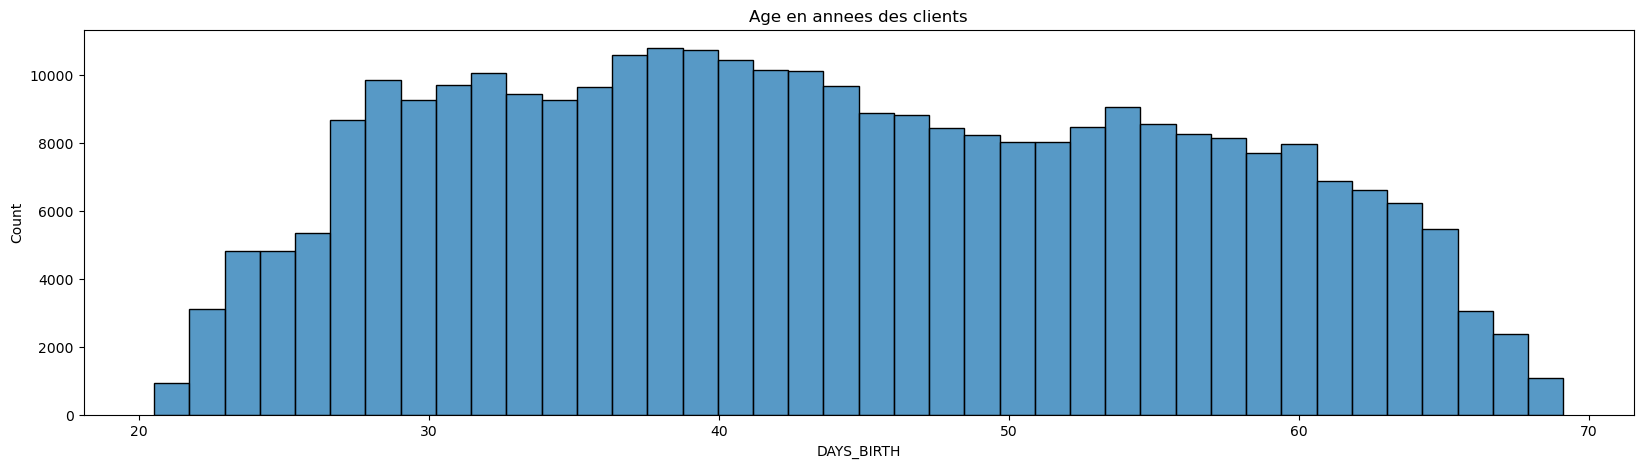

In [10]:
#distribution d'âge des clients
plt.figure(figsize=(20, 5))
sns.histplot(application_train['DAYS_BIRTH']*-1/365, bins = 40).set_title('Age en annees des clients')
plt.show()

In [11]:
#'DAYS_EMPLOYED':'How many days before the application the person started current employment'
application_train_num['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

**nous avons le max=365243/365 = 1000 annee ce n'est pas logique.Vérifions s'il s'agit d'une valeur aberrante isolée ou bien de plusieurs échantillons.**

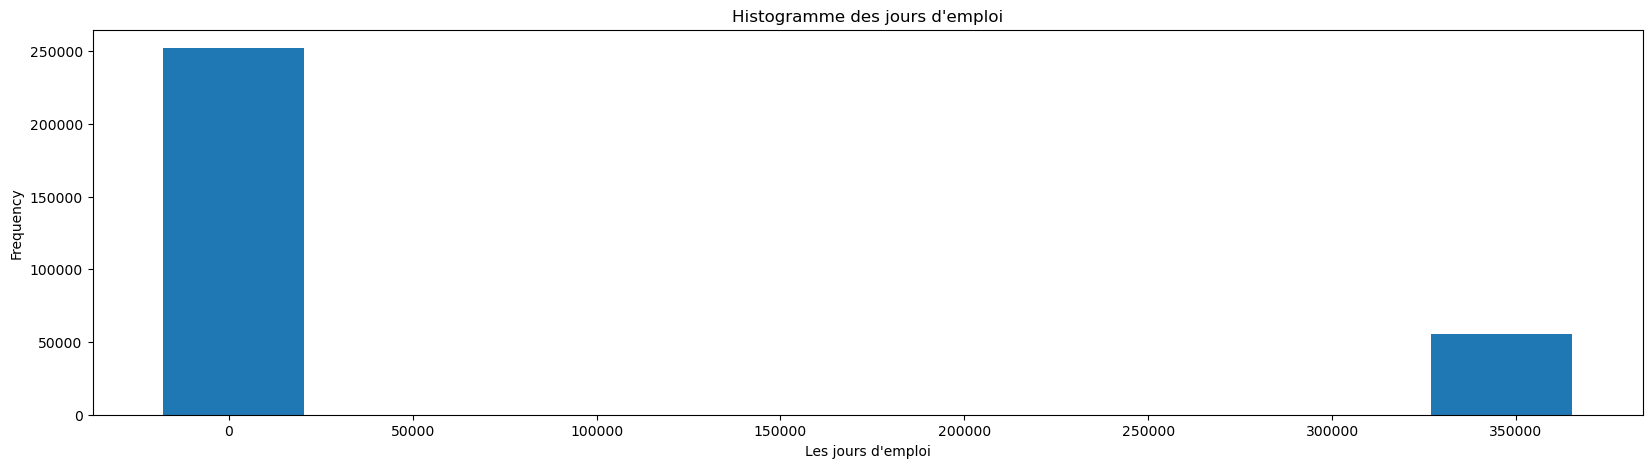

In [31]:
application_train['DAYS_EMPLOYED'].plot.hist(title = "Histogramme des jours d'emploi", figsize=(20,5));
plt.xlabel("Les jours d'emploi")
plt.show()

In [32]:
print("%0.0f valeur totale des jours de travail dans les données d'entrainement" % application_train.shape[0])
print("%0.0f valeurs avec 365243 jours de travail dans les données d'entrainement" % len(application_train[application_train['DAYS_EMPLOYED'] == 365243]))

307511 valeur totale des jours de travail dans les données d'entrainement
55374 valeurs avec 365243 jours de travail dans les données d'entrainement


**cette valeur aberrante n'est pas une valeur isolée. Nous allons la remplacer pas np.nan.
cela peut nous aider à identifier et analyser les points de données qui diffèrent considérablement du reste de l’ensemble de données.
En définissant une valeur, nous pouvons signaler tous les points de données qui sont egales a cette valerur et les étudier plus en détail.**

In [12]:
#Create an outliers flag column
application_train['DAYS_EMPLOYED_OUTLIERS'] = application_train["DAYS_EMPLOYED"] == 365243
application_test['DAYS_EMPLOYED_OUTLIERS'] = application_test["DAYS_EMPLOYED"] == 365243

In [13]:
# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# Replace the anomalous values with nan
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

**les variables categorielles**

In [35]:
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [41]:
#types de pret:cash ou renouvelable**
print(homecredit.loc[2,'Description'])
application_train['NAME_CONTRACT_TYPE'].value_counts()

Identification if loan is cash or revolving


NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

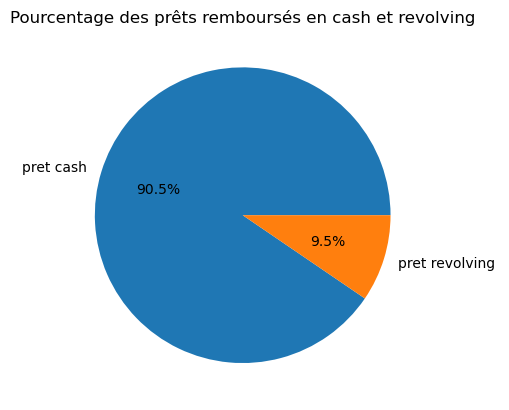

In [42]:
fig = plt.figure()
plt.pie(application_train['NAME_CONTRACT_TYPE'].value_counts()/len(application_train)*100,
        autopct='%1.1f%%',
        labels=["pret cash", "pret revolving "]
       )
plt.title('Pourcentage des prêts remboursés en cash et revolving')
plt.show()

In [44]:
#le sexe du client**
print(homecredit.loc[3,'Description'])
application_train['CODE_GENDER'].value_counts()

Gender of the client


CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

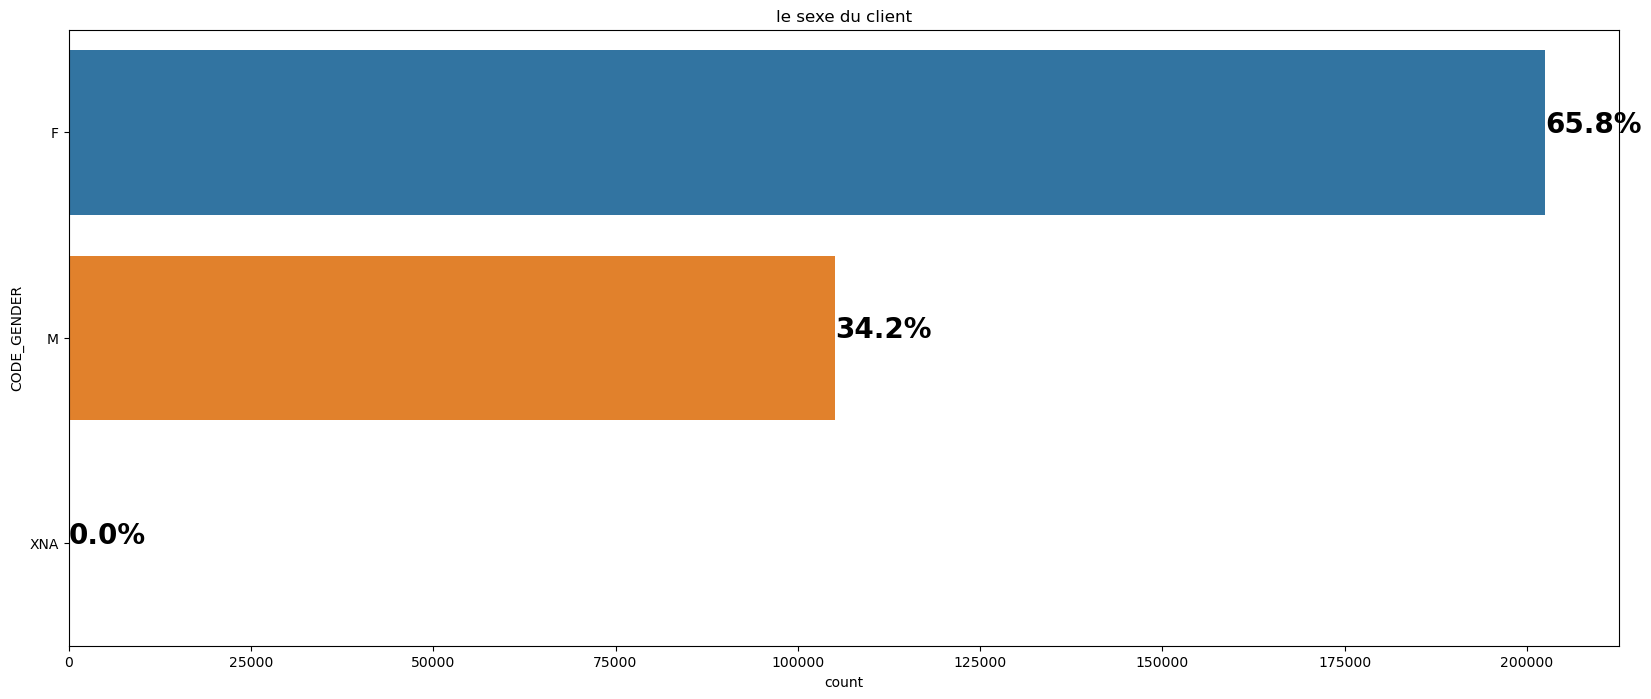

In [45]:
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y='CODE_GENDER', data=application_train, order=application_train['CODE_GENDER'].value_counts(ascending=False).index)
ax.set_title('le sexe du client')
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(application_train['CODE_GENDER']))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
        
plt.show()

**Le nombre femme est presque le double du nombre des hommes qui ont emprunté des crédits**

Flag if the client owns a car


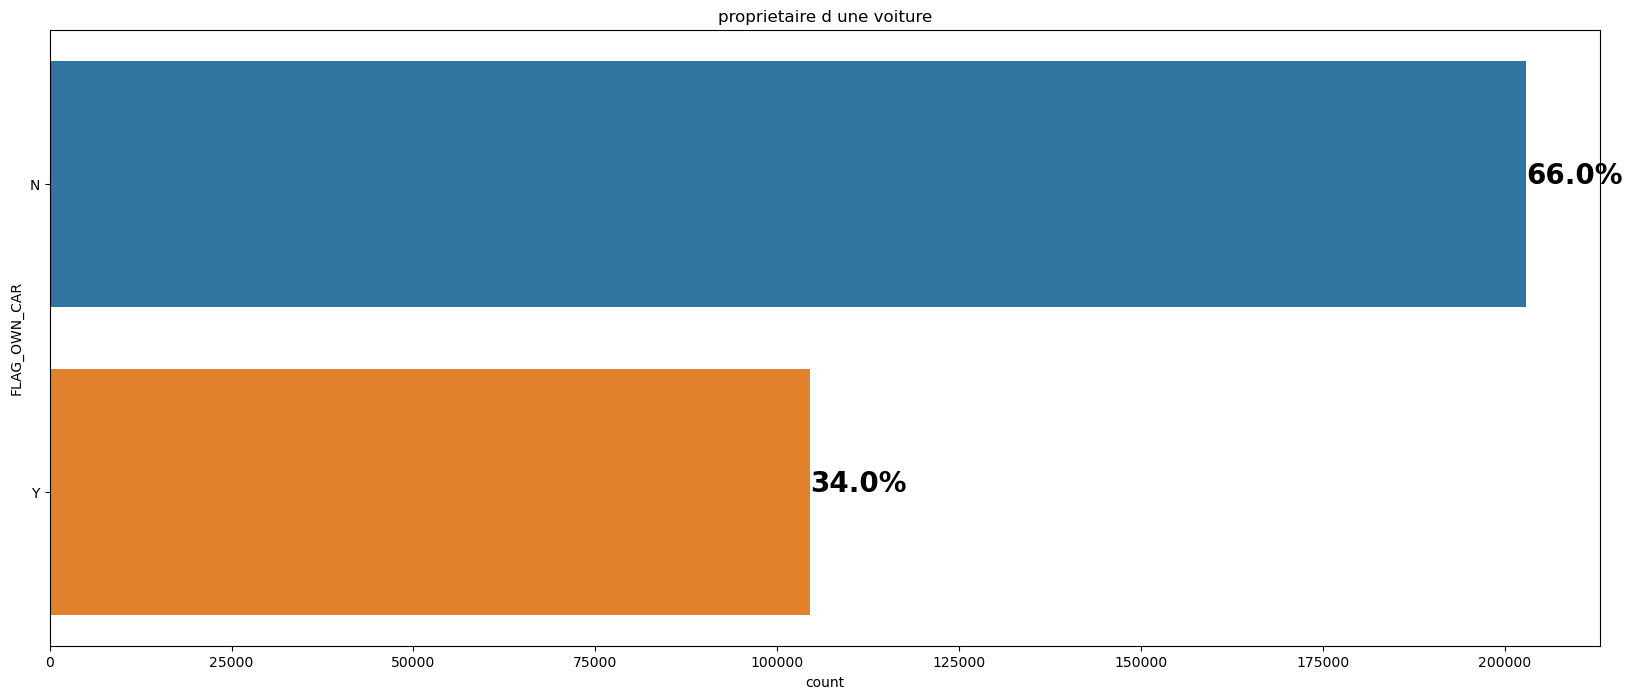

In [46]:
# Indique si le client a une voiture ou nn
print(homecredit.loc[4,'Description'])
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y='FLAG_OWN_CAR', data=application_train, order=application_train['FLAG_OWN_CAR'].value_counts(ascending=False).index)
ax.set_title('proprietaire d une voiture')
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(application_train['FLAG_OWN_CAR']))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
        
plt.show()

In [14]:
#encodage des variables categrielles
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_train:
    if application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
            application_test[col] = le.transform(application_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [15]:
# one-hot encoding of categorical variables
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 244)
Testing Features shape:  (48744, 240)


In [16]:
# les colonnes qui different les deux data: aplication_train et application_test
display(application_train.columns.difference(application_test.columns))

Index(['CODE_GENDER_XNA', 'NAME_FAMILY_STATUS_Unknown',
       'NAME_INCOME_TYPE_Maternity leave', 'TARGET'],
      dtype='object')

**Nous devons donc aligner les deux data,cad supprimer les difference entre les deux Sauf pout Target**

In [17]:
Target=application_train['TARGET']
# Align the training and testing data, keep only columns present in both dataframes
application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)

# Add the target back in
application_train['TARGET'] =Target

In [18]:
#verifiant mnt l'allignement
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 240)


#### les correlations bivariees avec la Target

In [19]:
correlations = application_train.corr()['TARGET'].sort_values()

In [20]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

*les plus grandes valeurs positives sont celles de 'Days_birth','AME_INCOME_TYPE_Working','REGION_RATING_CLIENT',
'REGION_RATING_CLIENT_W_CITY '**

*les plus grandes valeurs negatives sont celles de 'EXT_SOURCE 3','EXT_SOURCE 2','EXT_SOURCE 1', 'AGE _years'**

###### correlations positives avec la Target

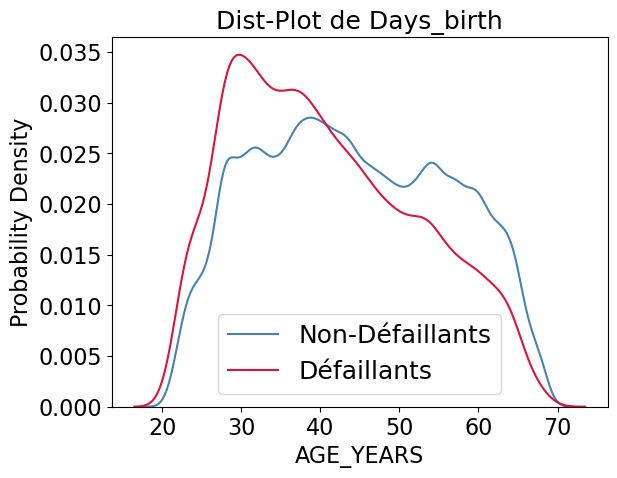

In [54]:
# relation entre  days_birth et target
sns.distplot((application_train['DAYS_BIRTH']/-365)[application_train['TARGET'] == 0].dropna(
            ), label='Non-Défaillants', hist=False, color='SteelBlue')

sns.distplot((application_train['DAYS_BIRTH']/-365)[application_train['TARGET'] == 1].dropna(), label='Défaillants', hist=False, color='Crimson')
plt.xlabel('AGE_YEARS', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.title("Dist-Plot de {}".format('Days_birth'), fontsize=18)
plt.show()

**le pic d'age  des defaillanst est vers le 30 ans avec une densite de probabilie de 0.035**

**le pic d'age  des non-defaillants est vers le 40 ans avec une densite de probabilie d 0.035**

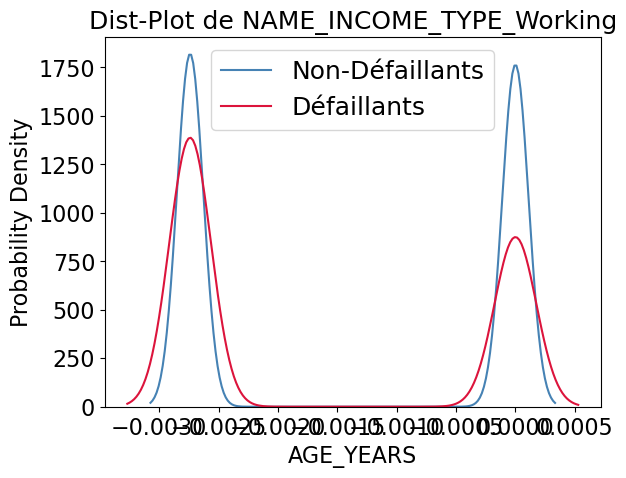

In [55]:
# relation entre  days_birth et target
sns.distplot((application_train['NAME_INCOME_TYPE_Working']/-365)[application_train['TARGET'] == 0].dropna(
            ), label='Non-Défaillants', hist=False, color='SteelBlue')

sns.distplot((application_train['NAME_INCOME_TYPE_Working']/-365)[application_train['TARGET'] == 1].dropna(), label='Défaillants', hist=False, color='Crimson')
plt.xlabel('AGE_YEARS', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.title("Dist-Plot de {}".format('NAME_INCOME_TYPE_Working'), fontsize=18)
plt.show()

##### les correlations negatives :

pour les correlations negatives :
il existe trois colonnes EXT_SOURCES, qui contiennent des valeurs comprises entre 0 et 1.
Il s'agit de scores normalisés provenant de différentes sources pour lesquels nous n'avons pas plus d'information

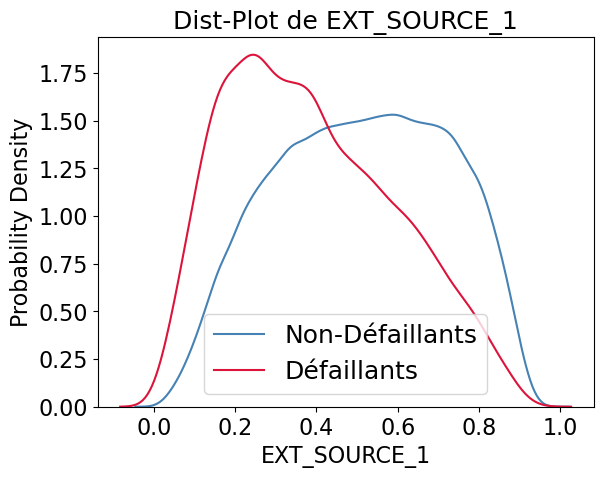

In [56]:
# relation entre  EXT_SOURCE et target
sns.distplot(application_train['EXT_SOURCE_1'][application_train['TARGET'] == 0].dropna(
            ), label='Non-Défaillants', hist=False, color='SteelBlue')

sns.distplot(application_train['EXT_SOURCE_1'][application_train['TARGET'] == 1].dropna(), label='Défaillants', hist=False, color='Crimson')
plt.xlabel('EXT_SOURCE_1', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.title("Dist-Plot de {}".format('EXT_SOURCE_1'), fontsize=18)
plt.show()

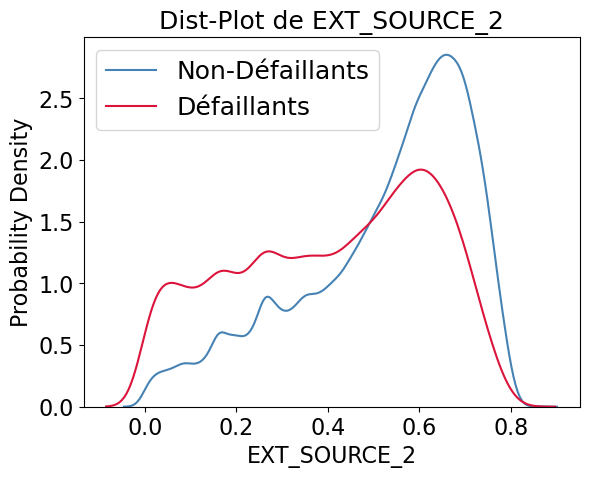

In [57]:
# relation entre  AGE_YEARS et target
sns.distplot(application_train['EXT_SOURCE_2'][application_train['TARGET'] == 0].dropna(
            ), label='Non-Défaillants', hist=False, color='SteelBlue')

sns.distplot(application_train['EXT_SOURCE_2'][application_train['TARGET'] == 1].dropna(), label='Défaillants', hist=False, color='Crimson')
plt.xlabel('EXT_SOURCE_2', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.title("Dist-Plot de {}".format('EXT_SOURCE_2'), fontsize=18)
plt.show()

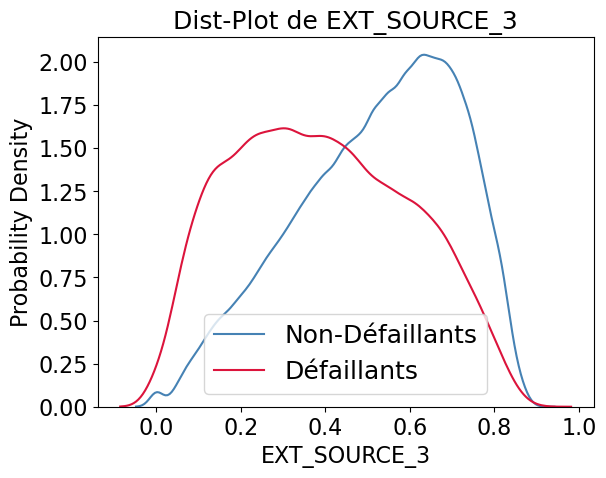

In [58]:
# relation entre  AGE_YEARS et target
sns.distplot(application_train['EXT_SOURCE_3'][application_train['TARGET'] == 0].dropna(
            ), label='Non-Défaillants', hist=False, color='SteelBlue')

sns.distplot(application_train['EXT_SOURCE_3'][application_train['TARGET'] == 1].dropna(), label='Défaillants', hist=False, color='Crimson')
plt.xlabel('EXT_SOURCE_3', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.title("Dist-Plot de {}".format('EXT_SOURCE_3'), fontsize=18)
plt.show()

**Les valeurs des défaillants ont tendance à avoir des valeurs  plus basses que les non-défaillants.Les non-défaillants montrent un pic plus élevé pour les valeurs élevées de EXT_SOURCE**

## Feature engineering 


-Création de nouvelles variables simples

-Catégorisation des variables binaires

-Imputation des valeurs manquantes

-Encodage des variables catégorielles

-Normalisation des variables numériques

### Creation de nouvelles features sur les deux data : application_train et application_test

In [21]:
#Création de feature
df_train = application_train.copy()
df_test = application_test.copy()

#Pourcentage du montant du crédit par rapport au revenu d'un client
df_train['CREDIT_INCOME_PERCENT'] = df_train['AMT_CREDIT'] /df_train['AMT_INCOME_TOTAL']
df_train['ANNUITY_INCOME_PERCENT'] = df_train['AMT_ANNUITY'] / df_train['AMT_INCOME_TOTAL']
#Durée du paiement en mois
df_train['CREDIT_TERM'] = df_train['AMT_ANNUITY'] / df_train['AMT_CREDIT']
# Pourcentage des jours employés par rapport à l'âge du client
df_train['DAYS_EMPLOYED_PERCENT'] = df_train['DAYS_EMPLOYED'] / df_train['DAYS_BIRTH']
#pourcentage des revenues des clients par rapport aux membres de la famille.
df_train['INCOME_PER_PERSON'] = df_train['AMT_INCOME_TOTAL'] / df_train['CNT_FAM_MEMBERS']

#test
#Pourcentage du montant du crédit par rapport au revenu d'un client
df_test['CREDIT_INCOME_PERCENT'] = df_test['AMT_CREDIT'] /df_test['AMT_INCOME_TOTAL']
df_test['ANNUITY_INCOME_PERCENT'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']
df_test['CREDIT_TERM'] = df_test['AMT_ANNUITY'] / df_test['AMT_CREDIT']
# Pourcentage des jours employés par rapport à l'âge du client
df_test['DAYS_EMPLOYED_PERCENT'] = df_test['DAYS_EMPLOYED'] / df_test['DAYS_BIRTH']
#pourcentage des revenues des clients par rapport aux membres de la famille.
df_test['INCOME_PER_PERSON'] = df_test['AMT_INCOME_TOTAL'] / df_test['CNT_FAM_MEMBERS']

features=df_train.copy()
test_features=df_test.copy()

# Extraction des ID
    
train_ids = features["SK_ID_CURR"]
test_ids = test_features["SK_ID_CURR"]
   
# Extraction des Targets
labels = features['TARGET']
    
#Suppression des ID and target
features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
test_features = test_features.drop(columns = ['SK_ID_CURR'])



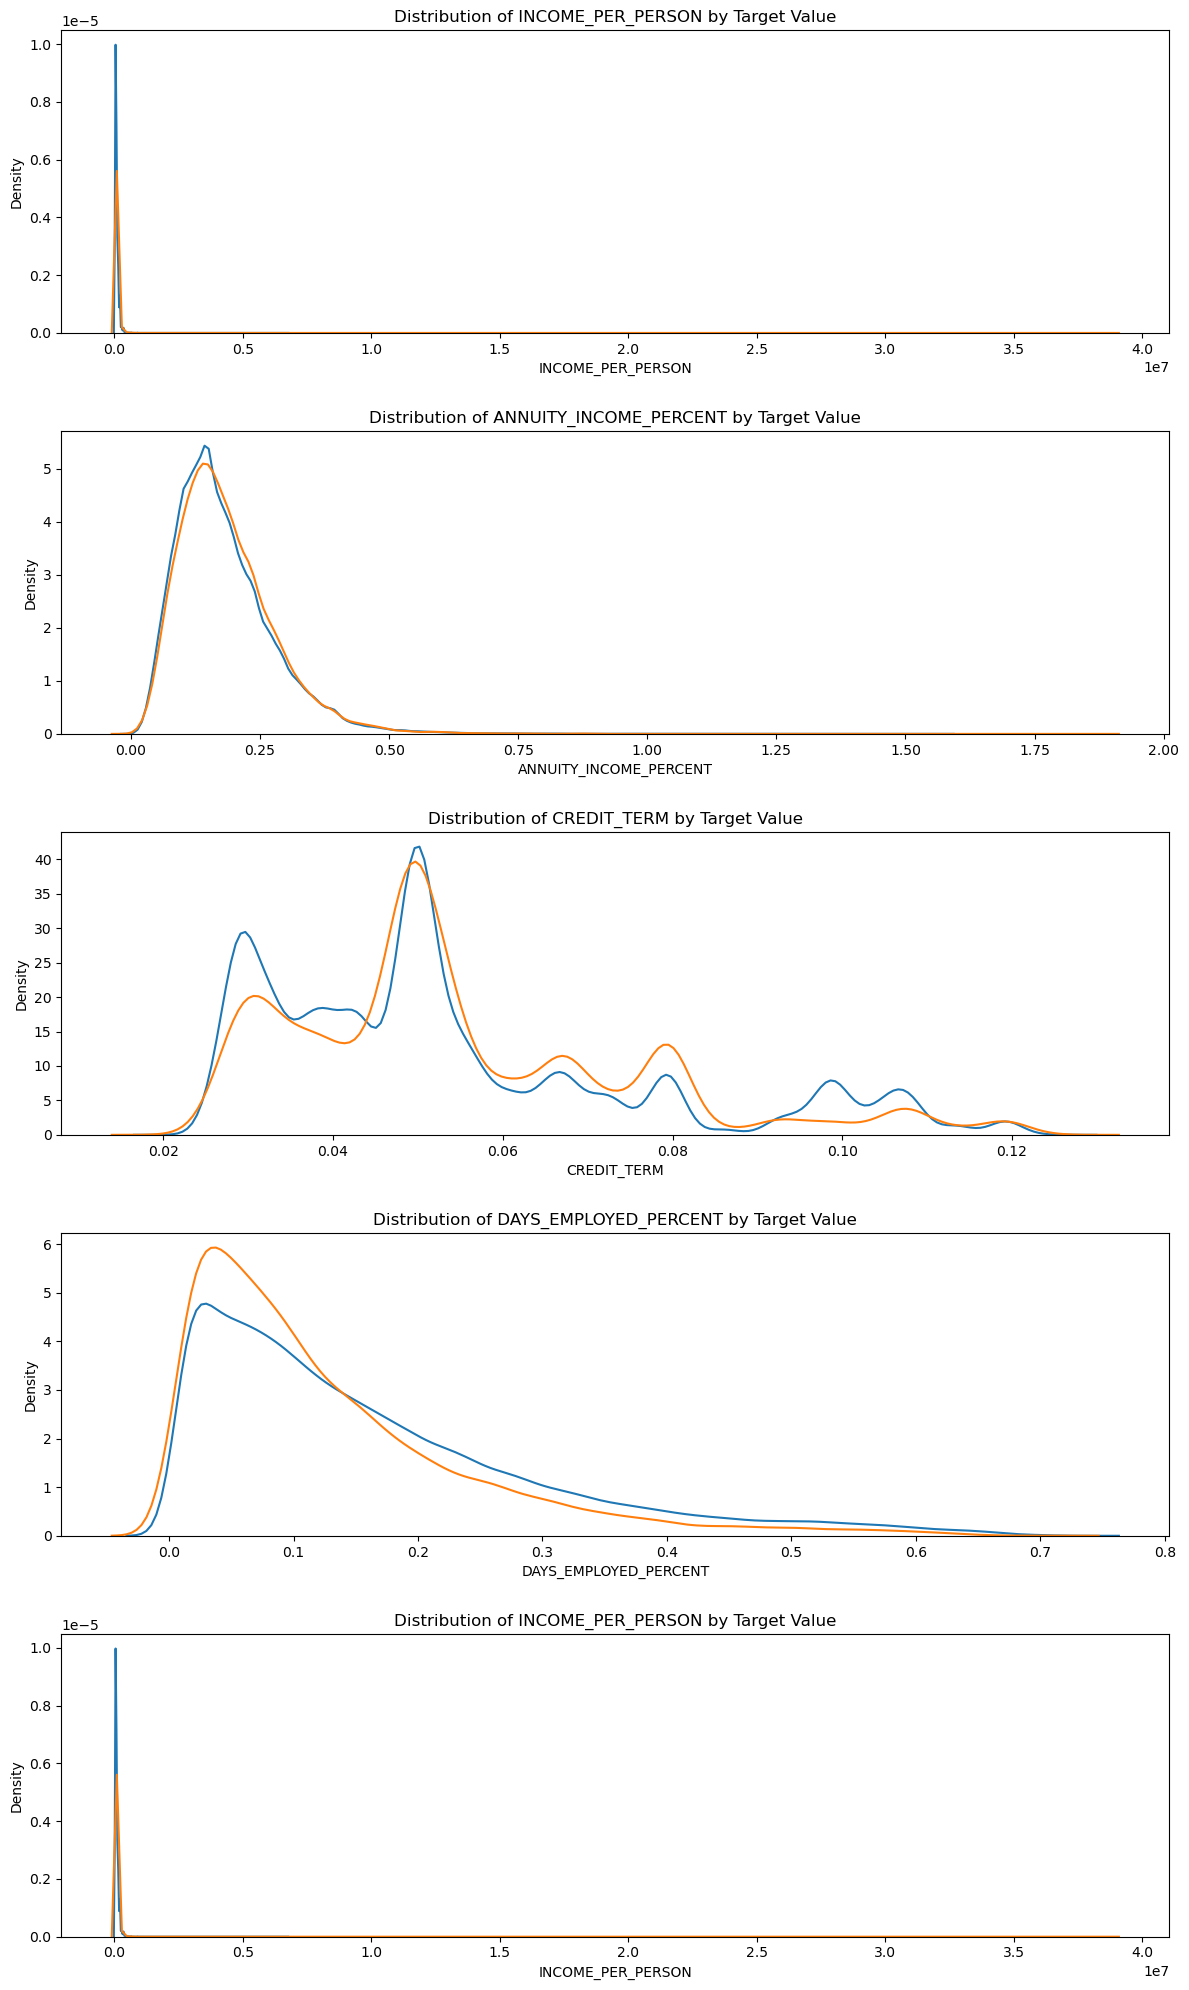

In [60]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['INCOME_PER_PERSON','ANNUITY_INCOME_PERCENT','CREDIT_TERM','DAYS_EMPLOYED_PERCENT','INCOME_PER_PERSON']):
    
    # create a new subplot for each source
    plt.subplot(5, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)


In [22]:
#encodage et one-hot
label_encoder = LabelEncoder()
    
categorical_columns_train  = []
categorical_columns_test  = []
    
for col in features :
        if col != "TARGET":
            if features[col].dtype == 'object':
                #Label encodage pour les variables binaires
                if features[col].nunique()==2:
                    features[col] = label_encoder.fit_transform(features[col])
                #récupération des colonnes où on fera un one hot encodage
                elif features[col].nunique()>2:
                    categorical_columns_train.append(col)
                    
features = pd.get_dummies(features, columns = categorical_columns_train,dummy_na= True)
    
for col in test_features :
        if test_features[col].dtype == object:
            #Label encodage pour les variables binaires
            if test_features[col].nunique()==2:
                test_features[col] = label_encoder.fit_transform(test_features[col])
            #récupération des colonnes où on fera un one hot encodage
            elif test_features[col].nunique()>2:
                categorical_columns_test.append(col)
    
test_features = pd.get_dummies(test_features,columns = categorical_columns_test, dummy_na= True)
    
#Alignement des dataframes
features, test_features = features.align(test_features, join= 'inner', axis=1)

In [23]:
# Extraction des noms des Feature
feat_name = list(features.columns)

In [24]:
#Imputation des Nan par la mediane
imputer = SimpleImputer(strategy = 'median')

features = imputer.fit_transform(features)
test_features = imputer.transform(test_features)

# Scale les features
scaler = MinMaxScaler(feature_range = (0, 1))

features = scaler.fit_transform(features)
test_features = scaler.transform(test_features)

# Création des dataset
features_set=pd.DataFrame(features,columns=feat_name)
test_features_set=pd.DataFrame(test_features,columns=feat_name)
    
#Ajout de la colonne TARGET et des ids
features_set['TARGET']=labels
features_set["SK_ID_CURR"] = train_ids
test_features_set['SK_ID_CURR'] = test_ids
    
#Passage des id en index
features_set.set_index('SK_ID_CURR', inplace = True)
test_features_set.set_index('SK_ID_CURR',inplace = True)

print('Training Data Shape: ', features_set.shape)
print('Testing Data Shape: ', test_features_set.shape)

Training Data Shape:  (307511, 245)
Testing Data Shape:  (48744, 244)


In [25]:
test_features_data= test_features_set.reset_index()
test_features_data.head(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,INCOME_PER_PERSON
0,100001,0.0,0.0,1.0,0.0,0.000935,0.130787,0.073886,0.102132,0.257000,...,0.0,1.0,0.0,1.0,0.0,0.049669,0.081075,0.137505,0.166084,0.001659
1,100005,0.0,0.0,1.0,0.0,0.000627,0.044387,0.061443,0.034792,0.491595,...,0.0,0.0,0.0,0.0,0.0,0.026500,0.093419,0.546137,0.339454,0.001197


In [10]:
#import joblib
test_features_data.to_csv("test_data.csv", index=False)
#joblib.dump(test_features_data, "test_data.joblib")

In [26]:
features_data= features_set.reset_index()

In [68]:
#data_drift = features_data.append(test_features_data, ignore_index=True)
data_drift = pd.concat([features_data, test_features_data], ignore_index=True)

In [69]:
#le data a utiliser pour la detection du data drift
sample_size = 1000  # Set the sample size
sample_data_drift = data_drift.sample(n=sample_size)

In [70]:
sample_data_drift.to_csv("sample_data_drift.csv", index=False)

### modelisation

In [27]:
X = features_set.drop(columns = 'TARGET')
y = features_set['TARGET']

In [28]:
#split notre data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246008, 244), (61503, 244), (246008,), (61503,))

#### DummyClassifier 

In [14]:
import mlflow
from mlflow.models import infer_signature
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [30]:
start_time = time.time()
dummyclassi=DummyClassifier()
dummyclassi.fit(X_train,y_train)
end_time = time.time()
print(f"Computation time  both models: {end_time - start_time:.4f} seconds")

Computation time  both models: 0.0288 seconds


In [31]:
roc_auc = roc_auc_score(y_test, dummyclassi.predict_proba(X_test)[:,1])
roc_auc

print(classification_report(y_test, dummyclassi.predict(X_test)))

y_pred=dummyclassi.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
conf_matrix

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



array([[56554,     0],
       [ 4949,     0]], dtype=int64)

In [32]:
def affichage_mconfus(y_true,y_pred):
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    group_names = ['Vrai Neg','Faux Pos','Faux Neg','Vrai Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    #sns.heatmap(cm, annot=labelss, fmt='', cmap='Blues')
    #plt.title('Matrice de confusion de logistic_regress')
    #plt.ylabel('Classe réelle')
    #plt.xlabel('Classe prédite')
    #plt.show()
    return labels

In [33]:
affichage_mconfus(y_test,y_pred)

array([['Vrai Neg\n56554\n91.95%', 'Faux Pos\n0\n0.00%'],
       ['Faux Neg\n4949\n8.05%', 'Vrai Pos\n0\n0.00%']], dtype='<U21')

<Figure size 600x400 with 0 Axes>

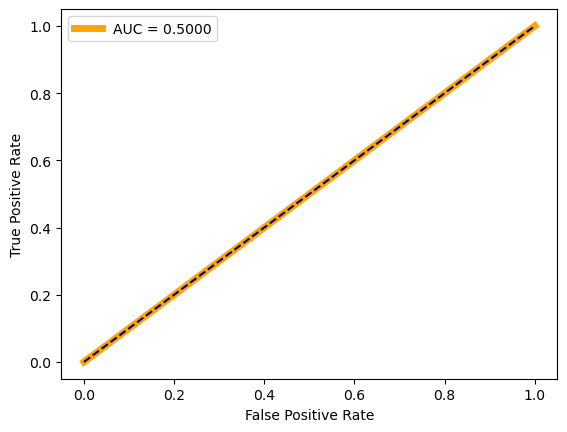

In [35]:
y_pred_proba=dummyclassi.predict_proba(X_test)[:,1]
plt.subplot(111)
fpr,tpr,_ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [36]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
params_dummy={'strategy' : 'stratified'}
# Create a new MLflow Experiment
mlflow.set_experiment("LogisticRegression")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_dummy)

    # Log the loss metric
    mlflow.log_metric("accuracy", roc_auc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("DummyClassifier Info", "Basic Dummy model ")

    # Infer the model signature
    signature = infer_signature(X_train, dummyclassi.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(artifact_path='Dummy_model',
        sk_model=dummyclassi,
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-dummuclassifier-basique",
    )



Successfully registered model 'tracking-dummuclassifier-basique'.
2024/05/14 18:51:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-dummuclassifier-basique, version 1
Created version '1' of model 'tracking-dummuclassifier-basique'.


#### LogisticRegression (C = 0.0001, max_iter=100)

In [34]:
start_time=time.time()
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
end_time=time.time()
print(f"Computation time for models: {end_time - start_time:.4f} seconds")

Computation time for models: 3.2009 seconds


In [35]:
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC=',roc_auc)

AUC= 0.6910416509742514


In [36]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



In [38]:
y_pred_lr=lr.predict(X_test)
affichage_mconfus(y_test,y_pred_lr)

array([['Vrai Neg\n56554\n91.95%', 'Faux Pos\n0\n0.00%'],
       ['Faux Neg\n4949\n8.05%', 'Vrai Pos\n0\n0.00%']], dtype='<U21')

<Figure size 600x400 with 0 Axes>

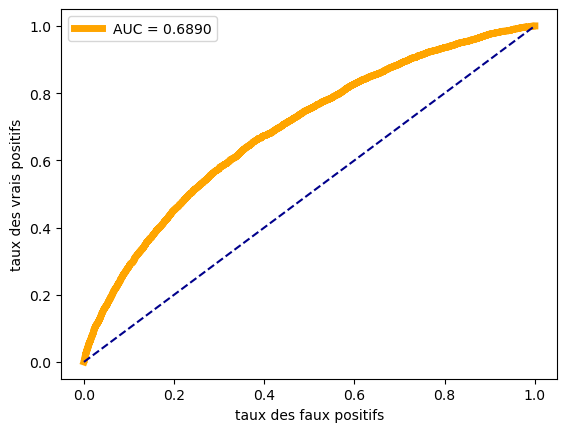

In [41]:
y_pred_proba=lr.predict_proba(X_test)[:,1]
plt.subplot(111)
fpr,tpr,_ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('taux des faux positifs')
plt.ylabel('taux des vrais positifs')
plt.legend()

In [44]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
params_LR={'C': 0.0001,'max_iter':100}
# Create a new MLflow Experiment
mlflow.set_experiment("LogisticRegression")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_LR)

    # Log the loss metric
    mlflow.log_metric("accuracy", roc_auc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Logistic Regression Info", "Basic LR model ")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(artifact_path='LR_model',
        sk_model=lr,
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-LR-basique",
    )



Registered model 'tracking-LR-basique' already exists. Creating a new version of this model...
2024/05/14 18:55:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-LR-basique, version 7
Created version '7' of model 'tracking-LR-basique'.


#### LightGBMClassifier

In [39]:
import re

def has_special_json_chars(string):
    pattern = r'[^\w\s]'
    return bool(re.search(pattern, string))

In [40]:
#our détecter et supprimer les caractères JSON spéciaux dans les noms de fonctionnalités en Python
#vous pouvez utiliser le remodule pour remplacer tous les caractères non alphanumériques par un trait de soulignement

def fix_feature_names(df):
    df.columns = [re.sub(r'\W+', '_', col) for col in df.columns]
    return df

# Apply the function to your DataFrame
X_train = fix_feature_names(X_train)
X_test = fix_feature_names(X_test)

In [41]:
start_time=time.time()
lgbm=lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
end_time=time.time()
print(f"Computation time for  models: {end_time - start_time:.4f} seconds")

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.325879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12590
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 237
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
Computation time for  models: 18.4783 seconds


In [42]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])
print('AUC=',roc_auc)

AUC= 0.7650936000149147


In [43]:
affichage_mconfus(y_test,lgbm.predict(X_test))

array([['Vrai Neg\n56457\n91.80%', 'Faux Pos\n97\n0.16%'],
       ['Faux Neg\n4827\n7.85%', 'Vrai Pos\n122\n0.20%']], dtype='<U21')

<Figure size 600x400 with 0 Axes>

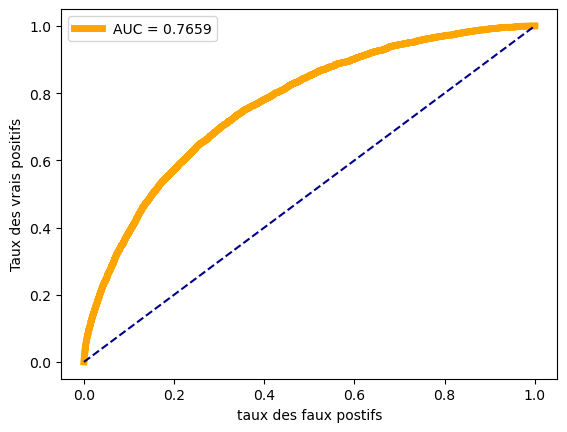

In [50]:
y_pred_proba=lgbm.predict_proba(X_test)[:,1]
plt.subplot(111)
fpr,tpr,_ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('taux des faux postifs')
plt.ylabel('Taux des vrais positifs')
plt.legend()

In [ ]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
params_LR={'colsample_bytree': 1.0,
       'learning_rate': 0.1,
        'max_depth': -1,
        'n_estimators': 100}
# Create a new MLflow Experiment
mlflow.set_experiment("LighGBM_basic")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_LR)

    # Log the loss metric
    mlflow.log_metric("accuracy", roc_auc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Lightgbm Info", "Basic LGBM model ")

    # Infer the model signature
    signature = infer_signature(X_train, lgbm.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(artifact_path='lgbm_model',
        sk_model=lgbm,
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-Lgbm-basique",
    )

In [44]:
modelS=[DummyClassifier(),LogisticRegression(),LGBMClassifier()]
name_model=[]
auc=[]
temps=[]
for model in modelS:
    start_time=time.time()
    model.fit(X_train,y_train)
    name_model.append(model)
    auc_model=round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),3)
    auc.append(auc_model)
    temps.append(time.time()-start_time)
resultats=pd.DataFrame(data=[name_model,auc,temps]).T
resultats.columns = ['Model', 'AUC','Time']   

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.292587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12590
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 237
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


In [45]:
resultats.sort_values(ascending=False,by='AUC')

,Model,AUC,Time
2,LGBMClassifier(),0.765,18.918639
1,LogisticRegression(),0.749,13.946272
0,DummyClassifier(),0.5,0.053087


#### Le traitement du déséquilibre des classes 

##### reequilibrage des donnees a l'aide de SMOTE
Nous allons essayer de resoudre ce surechantillonage a l'aide du SMOTE, et apres reentrainer les modeles 

In [46]:
print("Label 1,avant  SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, avant SMOTE: {} ".format(sum(y_train==0)))

Label 1,avant  SMOTE: 19876 
Label 0, avant SMOTE: 226132 


In [47]:
smote = SMOTE(random_state=2)
X_train_equil, y_train_equil = smote.fit_resample(X_train, y_train)

In [48]:
print("Label 1, apres SMOTE: {}".format(sum(y_train_equil==1)))
print("Label 0, apres SMOTE: {}".format(sum(y_train_equil==0)))

Label 1, apres SMOTE: 226132
Label 0, apres SMOTE: 226132


In [49]:
modelS=[DummyClassifier(),LogisticRegression(),LGBMClassifier()]
name_model=[]
auc=[]
temps=[]
for model in modelS:
    start_time=time.time()
    model.fit(X_train_equil,y_train_equil)
    name_model.append(model)
    auc_model=round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),3)
    auc.append(auc_model)
    temps.append(time.time()-start_time)
resultat=pd.DataFrame(data=[name_model,auc,temps]).T
resultat.columns = ['Model', 'AUC','Time']   

[LightGBM] [Info] Number of positive: 226132, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.761956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51046
[LightGBM] [Info] Number of data points in the train set: 452264, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [50]:
resultat

,Model,AUC,Time
0,DummyClassifier(),0.5,0.094924
1,LogisticRegression(),0.74,26.648193
2,LGBMClassifier(),0.746,52.411915


In [ ]:
lg=LGBMClassifier()
lg.fit(X_train_equil,y_train_equil)
y_lgb=lg.predict(X_test)
roc_auc = roc_auc_score(y_test, lg.predict_proba(X_test)[:,1])
mlflow.set_tracking_uri(uri="http://127.0.0.1:500")
params_gbm={'colsample_bytree': 1.0,
       'learning_rate': 0.1,
        'max_depth': -1,
        'n_estimators': 100}
# Create a new MLflow Experiment
mlflow.set_experiment("LighGBM_smote")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_gbm)

    # Log the loss metric
    mlflow.log_metric("accuracy", roc_auc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Lightgbm Info", " LGBM model-SMOTE ")

    # Infer the model signature
    signature = infer_signature(X_train_equil, lg.predict(X_test))

    # Log the model
    model_info = mlflow.sklearn.log_model(artifact_path='lgbm_mode_smotel',
        sk_model=lg,
        signature=signature,
        input_example=X_train_equil,
        registered_model_name="tracking-Lgbm-smote",
    )


In [ ]:
lr=LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_equil,y_train_equil)
y_lr=lr.predict(X_test)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

In [ ]:
lr=LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_equil,y_train_equil)
y_lr=lr.predict(X_test)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

In [100]:
rg=LogisticRegression()
rg.fit(X_train_equil,y_train_equil)
y_rg=rg.predict(X_test)
#affichage_mconfus(y_test,y_rg)
roc_auc = roc_auc_score(y_test, rg.predict_proba(X_test)[:,1])
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
params_LR={'C': 0.0001,'max_iter':100}
# Create a new MLflow Experiment
mlflow.set_experiment("regressionslogis_smote")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_LR)

    # Log the loss metric
    mlflow.log_metric("accuracy", roc_auc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag(" RL Info", " RegressionLogistic model-SMOTE ")

    # Infer the model signature
    signature = infer_signature(X_train_equil, rg.predict(X_test))

    # Log the model
    model_info = mlflow.sklearn.log_model(artifact_path='regression_mode_smotel',
        sk_model=rg,
        signature=signature,
        input_example=X_train_equil,
        registered_model_name="tracking-regression-smote",
    )


2024/05/03 14:22:57 INFO mlflow.tracking.fluent: Experiment with name 'regressionslogis_smote' does not exist. Creating a new experiment.
Successfully registered model 'tracking-regression-smote'.
2024/05/03 14:29:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-regression-smote, version 1
Created version '1' of model 'tracking-regression-smote'.


In [101]:
affichage_mconfus(y_test,y_rg)

array([['Vrai Neg\n39517\n64.25%', 'Faux Pos\n17037\n27.70%'],
       ['Faux Neg\n1711\n2.78%', 'Vrai Pos\n3238\n5.26%']], dtype='<U21')

<Figure size 600x400 with 0 Axes>

In [102]:
resultat['FN']=['NAN',2.78,7.92]

In [103]:
resultat

,Model,AUC,Time,FN
0,DummyClassifier(),0.5,0.036674,NAN
1,LogisticRegression(),0.74,19.892878,2.78
2,LGBMClassifier(),0.746,20.910193,7.92


### optimisation des hyperparametres de lightgbmclassifier (par rapport a la metrique cross_val)

In [23]:
def optimisation(params):
    params = {'n_estimators': int(params['n_estimators']),'learning_rate':params['learning_rate'], 'max_depth': int(params['max_depth'])}
    model = LGBMClassifier(**params)
    acc = cross_val_score(model, X_train_equil, y_train_equil,scoring="roc_auc", cv=StratifiedKFold(5)).mean()
    #seuil=params['seuil']
    #y_pred = acc > seuil
    return {"loss": -acc, "status": STATUS_OK}
space = {
    #'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'n_estimators': hp.quniform('n_estimators', 25, 500, 25),
    'max_depth': hp.quniform('max_depth', 1, 10, 1),
    #'seuil': hp.quniform('seuil', 0.0, 1.0, 0.025)

        }

best = fmin(fn=optimisation,
            space=space,
            algo=tpe.suggest,
            max_evals=30)

[LightGBM] [Info] Number of positive: 180906, number of negative: 180905                                               
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295322 seconds.                
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51720                                                                                     
[LightGBM] [Info] Number of data points in the train set: 361811, number of used features: 239                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000006                                         
[LightGBM] [Info] Start training from score 0.000006                                                                   
[LightGBM] [Info] Number of positive: 180906, number of negative: 180905                                               
[LightGBM] [Info] Auto-choosing row-wi

In [24]:
print(best)

{'learning_rate': 0.019940458926481563, 'max_depth': 7.0, 'n_estimators': 325.0}


In [25]:
lgbm_best =LGBMClassifier(n_estimators=325, max_depth=7,learning_rate=0.019)
lgbm_best.fit(X=X_train_equil,y=y_train_equil)

roc_auc = roc_auc_score(y_test, lgbm_best.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lgbm_best.predict(X_test)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 226132, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.402096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51539
[LightGBM] [Info] Number of data points in the train set: 452264, number of used features: 239
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.7198
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^

In [28]:
affichage_mconfus(y_test,lgbm_best.predict(X_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([['Vrai Neg\n56476\n91.83%', 'Faux Pos\n78\n0.13%'],
       ['Faux Neg\n4910\n7.98%', 'Vrai Pos\n39\n0.06%']], dtype='<U21')

<Figure size 600x400 with 0 Axes>

In [ ]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
params_lgbm={'learning_rate': 0.063, 
             'max_depth': 9.0, 
             'n_estimators': 150.0,
             'num_leaves': 110.0}
# Create a new MLflow Experiment
mlflow.set_experiment("LighGBM_optimi_techn")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_lgbm)

    # Log the loss metric
    mlflow.log_metric("accuracy", roc_auc_score(y_test, lgbm_best.predict_proba(X_test)[:,1]))

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Lightgbm optimisation technique Info", "LGBM model optimise1 ")

    # Infer the model signature
    signature = infer_signature(X_train_equil, lgbm_best.predict(X_train_equil))

    # Log the model
    model_info = mlflow.sklearn.log_model(artifact_path='lgbm_optim_tech',
        sk_model=lgbm_best,
        signature=signature,
        input_example=X_train_equil,
        registered_model_name="tracking-Lgbm-optim-techn",)

### Optimisation des hyperparametres  du lighgbmClassifier par rappor a la metrique metier

In [51]:
#fonction qi calcule le cout metier
def score_metier(y_true, y_pred):
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()
    score = 10*fn +fp
    return score

In [52]:
from hyperopt import hp

space = {
    'C': hp.loguniform('C', -4, 2),  # Distribution log-uniforme pour C
    'solver': hp.choice('solver', ['liblinear', 'lbfgs']),  # Choix entre liblinear et lbfgs
    'threshold': hp.uniform('threshold', 0.3, 0.7)  # Plage pour le seuil de prédiction
}

In [53]:
def objective(params):
    model = LogisticRegression(C=params['C'], solver=params['solver'])
    model.fit(X_train_equil, y_train_equil)

    # Ajuster le seuil de prédiction
    threshold = params['threshold']
    y_pred = (model.predict_proba(X_test)[:, 1] > threshold).astype(int)

    # Calculer la précision
    acc = score_metier(y_test,y_pred)
    return {"loss": -acc, "status": STATUS_OK} 

In [54]:
from hyperopt import fmin, tpe, Trials
import hyperopt.plotting as hplot
from sklearn.metrics import precision_score

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Meilleurs hyperparamètres et seuil :", best)

100%|██████████████████████████████████████████████████████████| 50/50 [44:24<00:00, 53.29s/trial, best loss: -43928.0]
Meilleurs hyperparamètres et seuil : {'C': 0.03604477015486364, 'solver': 1, 'threshold': 0.30053683822945826}


In [55]:
best_model = LogisticRegression(C=0.03, solver='lbfgs')
best_model.fit(X_train_equil, y_train_equil)

y_pred_test = (best_model.predict_proba(X_test)[:, 1] > 0.30).astype(int)

roc_auc = roc_auc_score(y_test,y_pred_test)
print('AUC : %0.3f' %roc_auc)
print(classification_report(y_test, best_model.predict(X_test)))
#print("Précision sur l'ensemble de test :", test_precision)

AUC : 0.640
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.16      0.65      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.67      0.53     61503
weighted avg       0.89      0.69      0.76     61503



In [56]:
affichage_mconfus(y_test,best_model.predict(X_test))

array([['Vrai Neg\n39429\n64.11%', 'Faux Pos\n17125\n27.84%'],
       ['Faux Neg\n1721\n2.80%', 'Vrai Pos\n3228\n5.25%']], dtype='<U21')

<Figure size 600x400 with 0 Axes>

In [36]:
space = {
    'C': hp.loguniform('C', -4, 2),  # Distribution log-uniforme pour C
    'solver': hp.choice('solver', ['liblinear', 'lbfgs']),  # Choix entre liblinear et lbfgs
    'threshold': hp.uniform('threshold', 0.3, 0.7)  # Plage pour le seuil de prédiction
}
def optimisation_hyper_thresh(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params_regress = {
        'C': params['C'],
        'solver': params['solver'],
        
        }
  
    
    model= LogisticRegression(**params_regress)
    threshold = params['threshold']

    cv = StratifiedKFold(5)
    eval_metric == 'custom_score' 
    y_proba = cross_val_predict(model, X_train_equil, y_train_equil, method='predict', cv=5)
    y_pred = (y_proba > threshold)
    y_pred = np.array(y_pred > 0) * 1
    score = score_metier(y_train_equil, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [37]:
best = fmin(fn=optimisation_hyper_thresh, space=space, max_evals=30,algo=tpe.suggest)


100%|█████████████████████████████████████████████████████| 30/30 [2:25:47<00:00, 291.57s/trial, best loss: -1689297.0]


In [38]:
print(best)

{'C': 6.612706060734044, 'solver': 0, 'threshold': 0.3346188126694482}


In [39]:
best_model = LogisticRegression(C=6.61, solver='liblinear')
best_model.fit(X_train_equil, y_train_equil)

y_pred_test = (best_model.predict_proba(X_test)[:, 1] > best['threshold']).astype(int)

roc_auc = roc_auc_score(y_test,y_pred_test)
print('AUC : %0.3f' %roc_auc)
print(classification_report(y_test, best_model.predict(X_test)))
#print("Précision sur l'ensemble de test :", test_precision)

AUC : 0.654
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.16      0.65      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.69      0.76     61503



In [64]:
affichage_mconfus(y_test,best_model.predict(X_test))

array([['Vrai Neg\n39469\n64.17%', 'Faux Pos\n17085\n27.78%'],
       ['Faux Neg\n1708\n2.78%', 'Vrai Pos\n3241\n5.27%']], dtype='<U21')

<Figure size 600x400 with 0 Axes>

**LGBMClassifier**

In [57]:
space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'n_estimators': hp.quniform('n_estimators', 25, 500, 25),
    'max_depth': hp.quniform('max_depth', 1, 10, 1),
    'threshold': hp.uniform('threshold', 0.3, 0.7) }
        # Plage pour le seuil de prédiction

    #'seuil': hp.quniform('seuil', 0.0, 1.0, 0.025)

def optimisation_hyper_thresh(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params_lighgbm = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'num_leaves':int(params['num_leaves'])
        #'subsample': params['subsample'],
        #'colsample_bytree': params['colsample_bytree'],
        #'reg_lambda': params['reg_lambda'],
        #'device':'gpu'
        }
  
    
    model= LGBMClassifier(**params_lighgbm)
    threshold = params['threshold']

    cv = StratifiedKFold(5)
    eval_metric == 'custom_score' 
    y_proba = cross_val_predict(model, X_train_equil, y_train_equil, method='predict', cv=5)
    y_pred = (y_proba > threshold)
    y_pred = np.array(y_pred > 0) * 1
    score = score_metier(y_train_equil, y_pred)
  
    loss = -score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [58]:
best = fmin(fn=optimisation_hyper_thresh, space=space, max_evals=30,algo=tpe.suggest)


[LightGBM] [Info] Number of positive: 180906, number of negative: 180905                                               
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.694928 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51272                                                                                     
[LightGBM] [Info] Number of data points in the train set: 361811, number of used features: 238                         
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000006                                         
[LightGBM] [Info] Start training from score 0.000006                                                                   
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                            

In [59]:
print(best)

{'learning_rate': 0.15156203887183511, 'max_depth': 8.0, 'n_estimators': 450.0, 'num_leaves': 64.0, 'threshold': 0.6280280935041935}


In [60]:
lgbm_best =LGBMClassifier(n_estimators=450,num_leaves=64, max_depth=8,learning_rate=0.19)
lgbm_best.fit(X=X_train_equil,y=y_train_equil)
y_pred_test = (lgbm_best.predict_proba(X_test)[:, 1] >0.62).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_test)
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lgbm_best.predict(X_test)))

[LightGBM] [Info] Number of positive: 226132, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.503544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51046
[LightGBM] [Info] Number of data points in the train set: 452264, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
AUC : 0.5103
              precision    re

In [61]:
affichage_mconfus(y_test,lgbm_best.predict(X_test))

array([['Vrai Neg\n56209\n91.39%', 'Faux Pos\n345\n0.56%'],
       ['Faux Neg\n4674\n7.60%', 'Vrai Pos\n275\n0.45%']], dtype='<U21')

<Figure size 600x400 with 0 Axes>

In [62]:
#optimisation avec gridsearch
from lightgbm import LGBMClassifier

# Diviser les données en ensembles d'entraînement et de test

# Définir les hyperparamètres à rechercher
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

# Créer le classificateur LightGBM
lgbm = LGBMClassifier()

# Créer un GridSearchCV avec la fonction de score personnalisée
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring=score_metier, cv=5, verbose=1)

# Exécuter la recherche
grid_search.fit(X_train_equil, y_train_equil)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 180906, number of negative: 180905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.352033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51272
[LightGBM] [Info] Number of data points in the train set: 361811, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Info] Number of positive: 180906, number of negative: 180905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.447344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50988
[LightGBM] [Info] Number of data points in t

In [64]:
meilleur_model = grid_search.best_estimator_
meilleur_model.fit(X_train_equil, y_train_equil)

# Prédictions de probabilités sur l'ensemble de test
y_probs = meilleur_model.predict_proba(X_test)[:, 1]

# Fonction pour trouver le meilleur seuil
def find_best_threshold(y_test, y_probs):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_score = float('inf')
    best_threshold = 0.5
    for threshold in thresholds:
        y_pred_labels = (y_probs >= threshold).astype(int)
        tp, tn, fp, fn = confusion_matrix(y_test, y_pred_labels).ravel()
        score = 10 * fn + fp
        if score < best_score:
            best_score = score
            best_threshold = threshold
    return best_threshold

# Trouver le meilleur seuil
best_threshold = find_best_threshold(y_test, y_probs)
print("Meilleur seuil de prédiction :", best_threshold)

# Prédictions finales avec le meilleur seuil
y_pred_best_threshold = (y_probs >= best_threshold).astype(int)


[LightGBM] [Info] Number of positive: 226132, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.952777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51046
[LightGBM] [Info] Number of data points in the train set: 452264, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleur seuil de prédiction : 0.61


In [65]:
auc = roc_auc_score(y_test, y_probs)
print("AUC :", auc)

# Rapport de classification
print(classification_report(y_test, y_pred_best_threshold))

AUC : 0.6628016973040134
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



In [60]:
import shap
#on cree un explicateur SHAP à l'aide du modèle lightgbm entraîné et de l'ensemble de données d'entraînement
explainer = shap.TreeExplainer(lgbm_best,X_test.iloc[:5, :])
#on calcule les valeurs SHAP pour l'ensemble de données de test à l'aide de l'explicateur.
shap_valuess = explainer(X_test.iloc[:5, :])

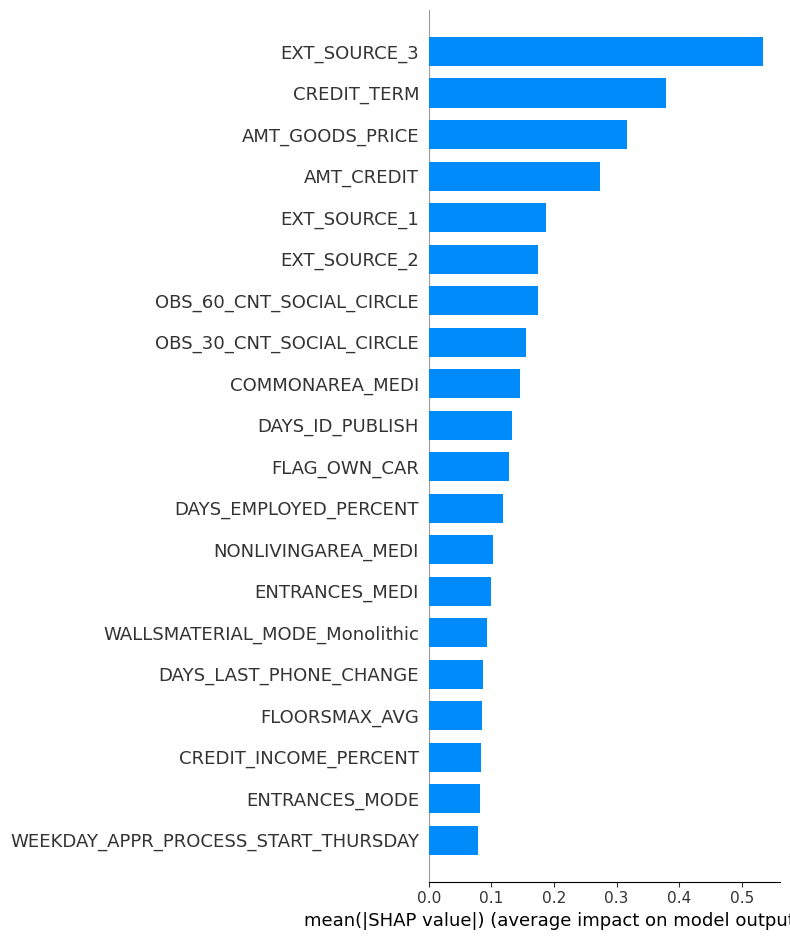

In [61]:
shap.summary_plot(shap_valuess, X_test.iloc[:5, :], 
                 feature_names= X_test.columns, plot_type="bar")

In [29]:
import shap
explainer = shap.TreeExplainer(lgbm_best)
shap_values = explainer.shap_values(X_test)

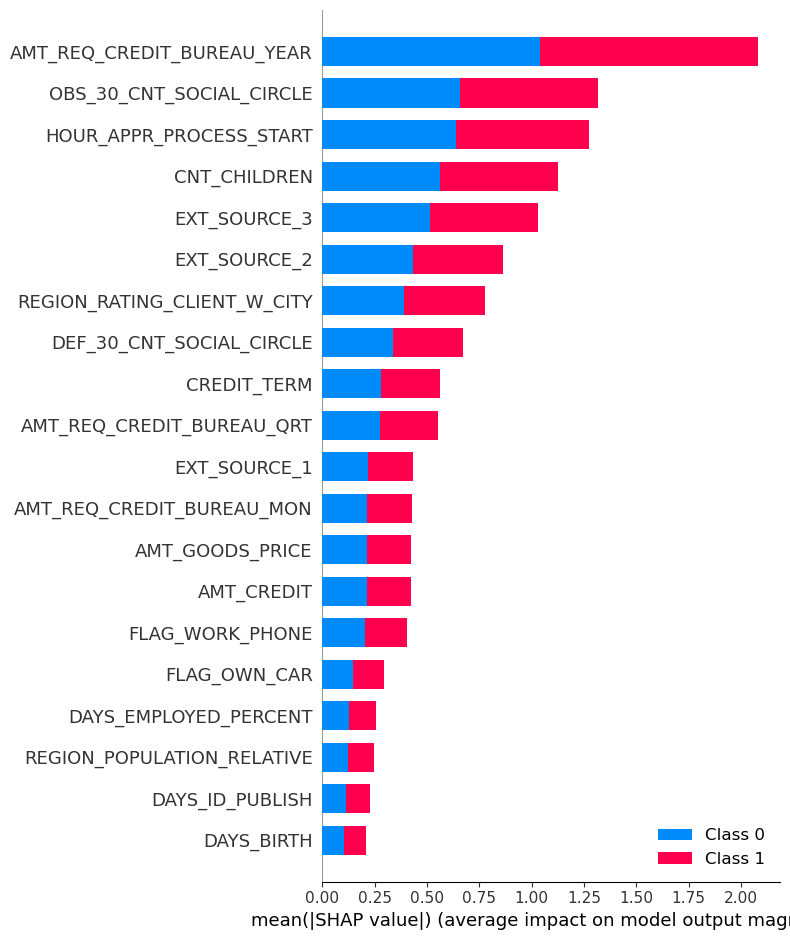

In [66]:
shap.summary_plot(shap_values, X_test, 
                 feature_names= X_test.columns, plot_type="bar")

In [67]:
lgbm_best.predict_proba(X_test)[0]

array([0.92356375, 0.07643625])

In [245]:
lgbm_best.predict(X_test)[0]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0

shap.plots.bar(shap_values[0])

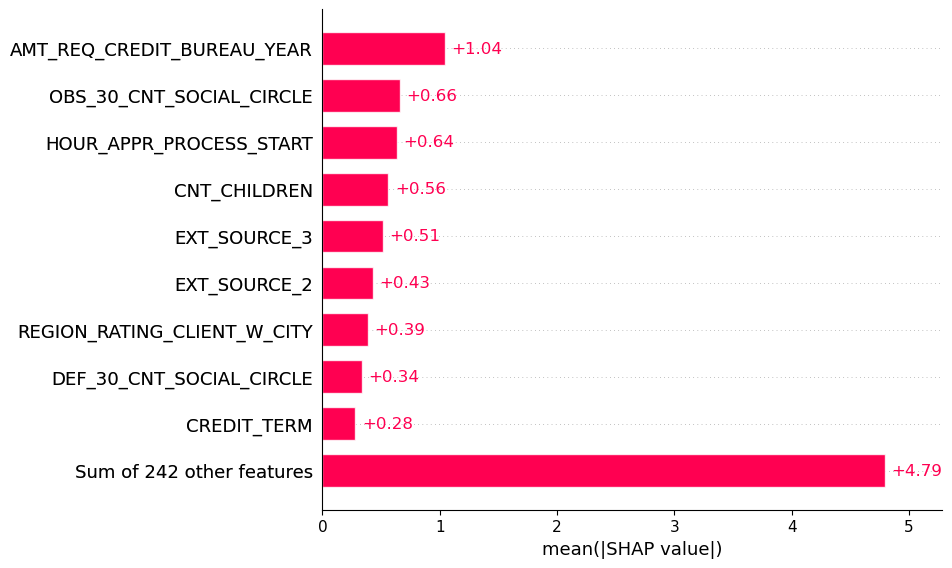

In [30]:
importance = explainer.shap_values(X_test)
shap_values = shap.Explanation(importance, feature_names=X_test.columns)
shap.plots.bar(shap_values[0])

In [ ]:
shap.plots.bar(-np.abs(shap_values[0]))